In [1]:
# Parameters
symbol = '^GSPC'
start_date = '1970'

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf

import numba
from scipy.optimize import minimize

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from IPython.display import set_matplotlib_formats

# set_matplotlib_formats('svg')
mpl.rcParams['figure.figsize'] = [16, 12]

/home/chiao/miniconda3/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [4]:
def plot_dd(rets):
    c_pl = rets.add(1).cumprod()

    c_pl.plot(lw=1, color='black', logy=True)
    plt.fill_between(
        c_pl.index,
        c_pl,
        c_pl.cummax(),
        facecolor='red',
        alpha=0.5,
    )

In [5]:
sg_cta = pd.read_csv("sg_indices.csv").rename(columns={"trade_date": "date"})
sg_cta["date"] = pd.to_datetime(sg_cta["date"])
sg_cta = sg_cta.set_index("date")
cta_ret = sg_cta["SG CTA Index"].transform(lambda xs: xs / xs.shift() - 1)

In [6]:
symbols = {}
for s in ["SPY", "AGG", "NTSX", "DBMF"]:
    df = yf.Ticker(s).history(period='max', auto_adjust=True)
    df.index = df.index.tz_convert(None).floor("D")
    df["ret"] = df["Close"].transform(lambda xs: xs / xs.shift() - 1)
    symbols[s.lower()] = df

In [7]:
rets = pd.DataFrame({k: v["ret"] for k, v in symbols.items()})
rets["cta"] = cta_ret
rets = rets.dropna(subset=["spy", "agg", "cta"])

In [8]:
from sklearn.linear_model import LinearRegression

dbmf_calibration_df = rets[["cta", "dbmf"]].dropna()

model = LinearRegression()
model.fit(dbmf_calibration_df[["cta"]], dbmf_calibration_df["dbmf"])

dbmf_pred = model.predict(rets[["cta"]])

rets["dbmf_pred"] = dbmf_pred

In [9]:
rets["60_40_33"] = rets.eval("0.6 * spy + 0.4 * agg + 0.33 * dbmf_pred")
rets["90_60_50"] = rets.eval("0.9 * spy + 0.6 * agg + 0.50 * dbmf_pred")

In [10]:
rets.add(1).apply(np.log).mean().mul(250).apply(np.exp).sub(1)

spy          0.102420
agg          0.028870
ntsx         0.106688
dbmf         0.082462
cta          0.034708
dbmf_pred    0.057096
60_40_33     0.098041
90_60_50     0.145011
dtype: float64

In [11]:
rets = rets[["spy", "agg", "dbmf_pred", "60_40_33", "90_60_50"]]

<AxesSubplot: xlabel='Date'>

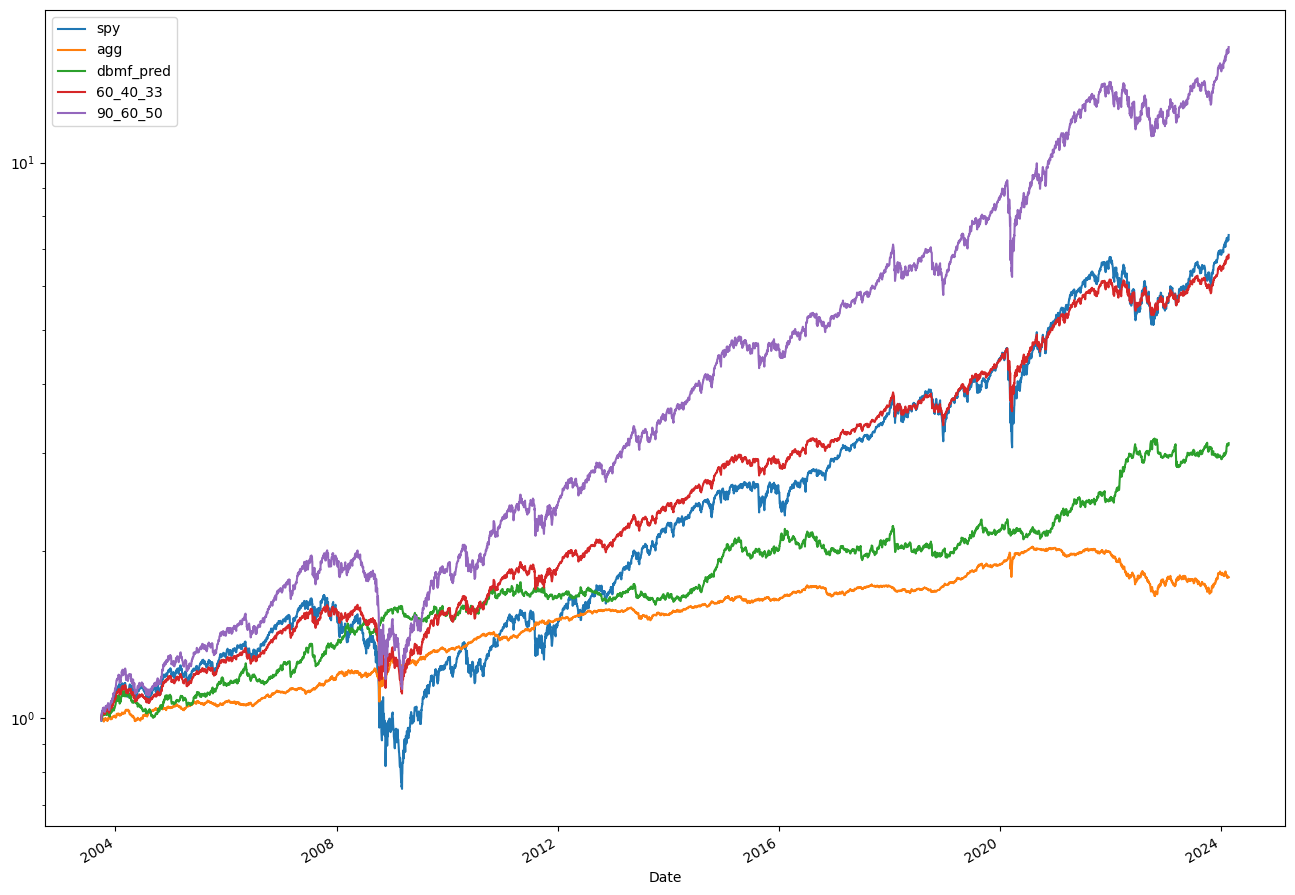

In [26]:
rets.add(1).cumprod().plot(logy=True)

<AxesSubplot: title={'center': 'Total Return (X times)'}, xlabel='Date'>

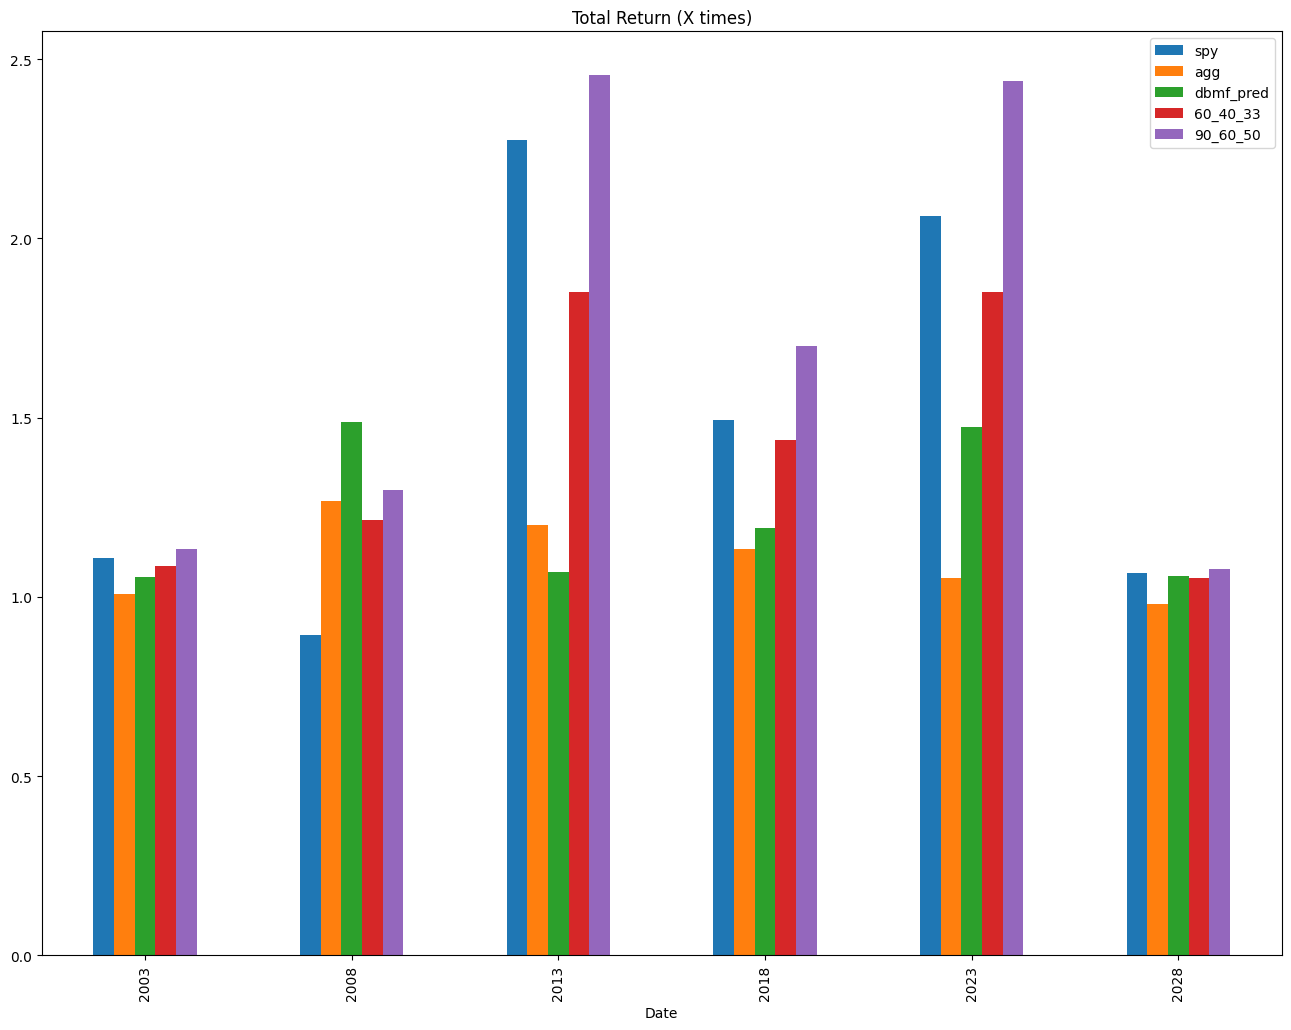

In [35]:
(
    rets.add(1).groupby(pd.Grouper(freq="5Y")).prod()
    .rename(index=lambda xs: xs.date().year)
    .plot.bar(title="Total Return (X times)")
)

<AxesSubplot: title={'center': 'Worst Drawdown'}, xlabel='Date'>

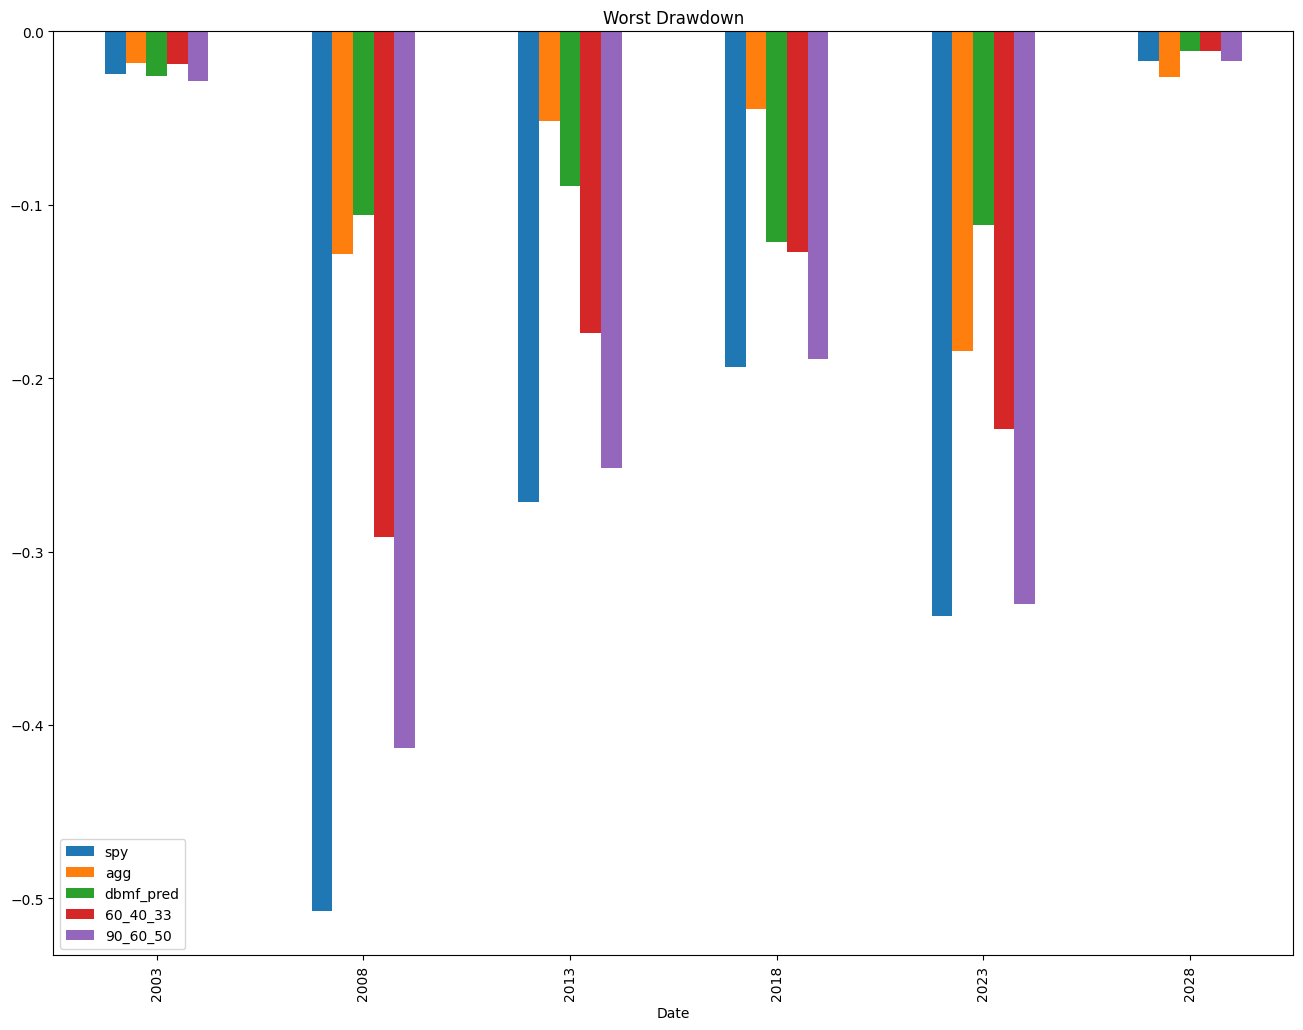

In [32]:
(
    rets.add(1).cumprod()
    .groupby(pd.Grouper(freq="5Y"))
    .apply(lambda xs: (xs / xs.cummax() - 1).min())
    .rename(index=lambda xs: xs.date().year)    
    .plot.bar(title="Worst Drawdown")
)

In [15]:
sharpe = lambda xs: xs.mean() / xs.std() * 250**0.5

In [18]:
rets.std().mul(250**0.5)

spy          0.187915
agg          0.052014
dbmf_pred    0.078569
60_40_33     0.117059
90_60_50     0.175674
dtype: float64

In [19]:
rets.mean().mul(250)

spy          0.115204
agg          0.029822
dbmf_pred    0.058625
60_40_33     0.100397
90_60_50     0.150888
dtype: float64

In [20]:
def logret(r):
    return -r.add(1).apply(np.log).mean().mul(250).apply(np.exp).sub(1)

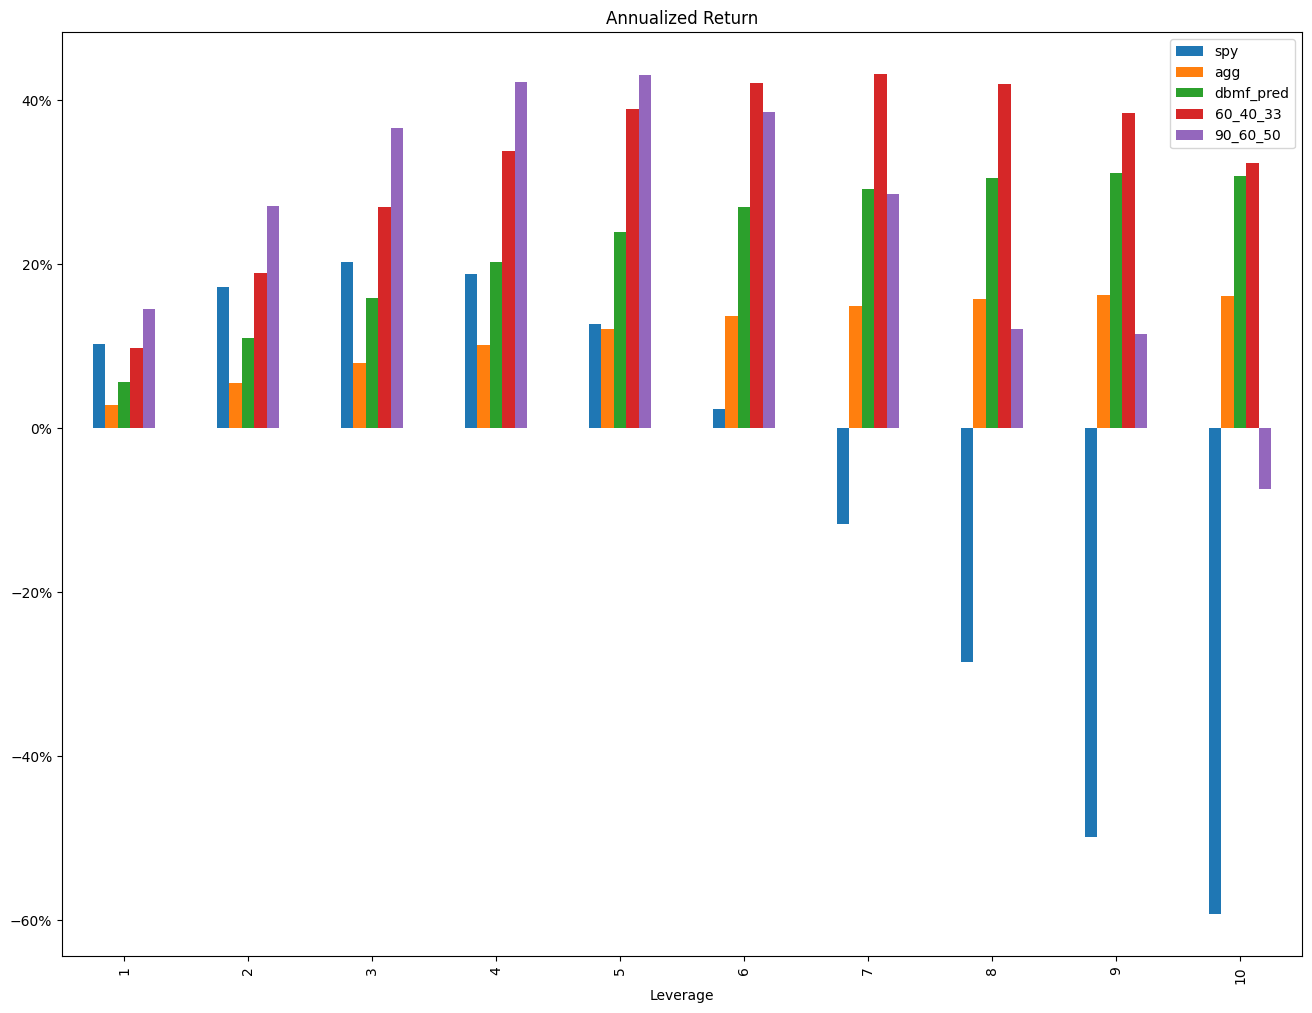

In [42]:
ax = (
    pd.concat([-logret(l * rets).rename(l) for l in range(1, 11)], axis=1)
    .T.plot.bar(title="Annualized Return")
)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
ax.set_xlabel("Leverage");